Preparing the dataset same as the one uploaded into the Teachable Machine so as to evaluate the performance and metrics.

All 40 files from the Cough class and 40 files from the Non-Cough class have been considered.

The Downloaded model is available in the path /content/drive/MyDrive/keras_model.h5

In [40]:
# Importing the required dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

audio_files='/content/drive/MyDrive/ESC-50-master/audio/'
metadata=pd.read_csv('/content/drive/MyDrive/ESC-50-master/meta/esc50.csv')
metadata.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [3]:
# Creating another dataframe for the metadata to hold only the audio file categories that we will need for our analysis (200 records)
metadata_new1 = metadata['target'].isin(['24', '30', '10','0','22'])
metadata_new = metadata[metadata_new1]
metadata_new

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
6,1-101336-A-30.wav,1,30,door_wood_knock,False,101336,A
9,1-103995-A-30.wav,1,30,door_wood_knock,False,103995,A
10,1-103999-A-30.wav,1,30,door_wood_knock,False,103999,A
11,1-104089-A-22.wav,1,22,clapping,False,104089,A
...,...,...,...,...,...,...,...
1949,5-251489-A-24.wav,5,24,coughing,False,251489,A
1965,5-254160-A-22.wav,5,22,clapping,False,254160,A
1969,5-256512-A-30.wav,5,30,door_wood_knock,False,256512,A
1988,5-262957-A-22.wav,5,22,clapping,False,262957,A


In [4]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=20)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)    
    return mfccs_scaled_features

In [7]:
import numpy as np
import librosa
import os
from tqdm import tqdm  #  Instantly make your loops show a smart progress meter
# Now we iterate through every audio file in the metadata and extract features for each audio file
extracted_features=[]
for i,row in tqdm(metadata_new.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_files),str(row["filename"]))
    class_name=row["category"]
    data=extract_features(file_name)
    extracted_features.append([data,class_name])

200it [01:05,  3.05it/s]


In [8]:
# converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-601.3449, 5.261408, -9.065388, -3.7297595, -...",dog
1,"[-435.18063, 105.92404, 13.725261, 19.623205, ...",door_wood_knock
2,"[-569.14136, 40.56101, 5.5717382, 4.1844625, 4...",door_wood_knock
3,"[-641.6269, 39.85432, 3.6132596, 1.085563, 4.6...",door_wood_knock
4,"[-94.37435, 46.090195, -62.937862, -19.831861,...",clapping


In [9]:
extracted_features_df['Label']=" "

In [10]:
extracted_features_df.loc[extracted_features_df['class'].isin(['dog','door_wood_knock','rain','clapping']),'class'] = 'Not Cough'
extracted_features_df.loc[extracted_features_df['class'].isin(['coughing']),'class'] = 'Cough'

In [11]:
extracted_features_df.loc[extracted_features_df['class'] == 'Cough' , 'Label'] = '0'
extracted_features_df.loc[extracted_features_df['class'] == 'Not Cough' , 'Label'] = '1'

In [12]:
extracted_features_df['Label'].value_counts()

1    160
0     40
Name: Label, dtype: int64

For Teachable machine, we have uploaded 40 Cough files and 40 files from all other classes. So we will first get these files and make dataframes to hold the test and train data (30 for Train , and 10 for test in each class)

In [14]:
extracted_features_df.drop('class', axis=1, inplace=True)


In [16]:
cough_df = extracted_features_df[extracted_features_df['Label'] =='0']
cough_df.shape

(40, 2)

In [17]:
not_cough_df = extracted_features_df[extracted_features_df['Label'] =='1']
not_cough_df.shape

(160, 2)

In [18]:
not_cough=not_cough_df.head(40)
not_cough.shape

(40, 2)

In [ ]:
not_cough['Label'] = pd.to_numeric(not_cough['Label'])

In [ ]:
cough_df['Label'] = pd.to_numeric(cough_df['Label'])

In [33]:
# Splitting the Cough dataframe for Train and Test data
cough_df_train=cough_df.head(30)
cough_df_test=cough_df.tail(10)

In [34]:
print(cough_df_train.shape)
print(cough_df_test.shape)

(30, 2)
(10, 2)


In [35]:
# Splitting the Not Cough dataframe for Train and Test data
not_cough_train=not_cough.head(30)
not_cough_test=not_cough.tail(10)
print(not_cough_train.shape)
print(not_cough_test.shape)

(30, 2)
(10, 2)


In [ ]:
# Combining the Test data for Cough and Not Cough data
test_data_df=cough_df_test.append(not_cough_test)

In [ ]:
# Combining the Test data for Cough and Not Cough data
train_data_df=cough_df_train.append(not_cough_train)

Evaluation the Model downloaded from Teachable Machine for Test data

In [58]:
# For Test Data (20 records)
from keras.models import load_model
from PIL import Image, ImageOps
import numpy as np

# Load the model and executing for Cough Test data
model = load_model('/content/drive/MyDrive/keras_model.h5')
model.compile(loss = 'binary_crossentropy',metrics=['accuracy'],optimizer='adam')

# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1.
data_test = np.ndarray(shape=(1,224, 224,3), dtype=np.float32)
y_pred_test=[]
# Replace this with the path to your image
for i in range(31,51):
  image1 = Image.open('/content/drive/MyDrive/ESC-50-master/Final-samples-for teachable/test_files_20/download ('+str(i)+').png').convert('RGB')
  #resize the image to a 224x224 with the same strategy as in TM2:
  #resizing the image to be at least 224x224 and then cropping from the center
  size1 = (224, 224)
  image1 = ImageOps.fit(image1, size1, Image.ANTIALIAS)

  #turn the image into a numpy array
  image_array1 = np.asarray(image1)
  # Normalize the image
  normalized_image_array1 = (image_array1.astype(np.float32) / 127.0) - 1
  # Load the image into the array
  data_test[0] = normalized_image_array1

  # run the inference
  prediction_test = model.predict(data_test)
  predicted_class_test=np.argmax(prediction_test[0],axis=0)
  y_pred_test.append(predicted_class_test)
  print(prediction_test, predicted_class_test)

[[9.9999964e-01 3.0043617e-07]] 0
[[0.96840936 0.03159064]] 0
[[0.9989091  0.00109094]] 0
[[0.993779   0.00622093]] 0
[[9.994741e-01 5.258627e-04]] 0
[[9.9950516e-01 4.9482082e-04]] 0
[[0.9976681  0.00233186]] 0
[[0.9989091  0.00109094]] 0
[[0.99892706 0.00107289]] 0
[[2.2544198e-05 9.9997747e-01]] 1
[[1.4940782e-04 9.9985051e-01]] 1
[[0.02348996 0.97651005]] 1
[[0.2149468 0.7850532]] 1
[[1.7029876e-04 9.9982965e-01]] 1
[[0.43875158 0.5612485 ]] 1
[[0.00535048 0.99464947]] 1
[[0.9822609  0.01773907]] 0
[[0.10512983 0.89487016]] 1
[[0.9974529 0.0025471]] 0
[[0.9535604  0.04643956]] 0


In [59]:
from sklearn.metrics import classification_report, confusion_matrix
# Classification Report for the Cough Test data
print(classification_report(test_data_df['Label'].values,y_pred_test))
cm_test=confusion_matrix(test_data_df['Label'].values,y_pred_test)
cm_test

              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.88      0.70      0.78        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20



array([[9, 1],
       [3, 7]])

[Text(0, 0.5, 'Cough'), Text(0, 1.5, ' Not cough')]

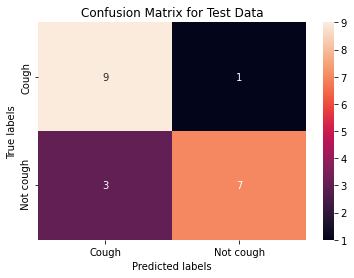

In [60]:
ax= plt.subplot()
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix for Test Data')
ax.xaxis.set_ticklabels(['Cough', 'Not cough'])
ax.yaxis.set_ticklabels(['Cough', ' Not cough'])

Conclusion:

The model from the Teachable Machine predicts the outcome with 80% accuracy on the test data and the Confusion matrix look fine. But however the data samples used here are very less and hence the performnace can be further improved by increasing the number of samples for the train and test dataset